In [12]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 18 12:42:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:AE:00.0 Off |                   On |
| N/A   41C    P0             69W /  300W |   37445MiB /  81920MiB |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [13]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 270.0 gigabytes of available RAM

You are using a high-RAM runtime!


In [14]:
# Provides a way of using operating system-dependent functionality, such as file manipulation and environment variables.
import os  

# PyTorch library for tensor computations and deep learning, providing essential tools for neural network construction and training.
import torch  

# Pandas library for data manipulation and analysis, used for handling datasets, particularly in tabular form.
import pandas as pd  

# Hugging Face Transformers library for loading pre-trained sequence-to-sequence models, tokenizers, and training utilities.
# Includes support for setting up learning rate schedulers.
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments, get_scheduler  

# Datasets library for handling datasets in a standardized format and evaluation metrics for model performance.
from datasets import Dataset, load_metric  

# PyTorch's implementation of the Adam optimizer with weight decay, commonly used for training deep learning models.
from torch.optim import AdamW  

# Matplotlib library for creating static, animated, and interactive visualizations, used for plotting training metrics.
import matplotlib.pyplot as plt  

# JSON library for parsing and handling JSON formatted data, useful for reading and writing configuration files or data exchanges.
import json  

# Time library for time-related functions, useful for measuring elapsed time or implementing delays.
import time  

# It provides support for arrays, matrices, and many mathematical functions
import numpy as np

In [15]:
# Path to the output CSV file
output_file = './coreference_batches.csv'

full_df = pd.read_csv(output_file)

# Randomly pick 3000 rows
cleaned_df = full_df.sample(n=3000, random_state=42)
# cleaned_df = full_df

# Rename 'processed_description' to 'cleaned_description'
cleaned_df.rename(columns={'processed_description': 'cleaned_description'}, inplace=True)

# Rename 'processed_abstract' to 'cleaned_abstract'
cleaned_df.rename(columns={'processed_abstract': 'cleaned_abstract'}, inplace=True)

# Rename 'processed_processed_description' to 'coreference_description'
cleaned_df.rename(columns={'processed_processed_description': 'coreference_description'}, inplace=True)

# Rename 'processed_processed_abstract' to 'coreference_abstract'
cleaned_df.rename(columns={'processed_processed_abstract': 'coreference_abstract'}, inplace=True)

In [23]:
class TextSummarizationTrainer:
    """
    A class for training, evaluating, and utilizing a text summarization model.

    Attributes:
        dataframe (pandas.DataFrame): The dataset containing input texts and target summaries.
        model_name (str): The identifier for the pretrained model (e.g., "t5-small").
        max_input_length (int): Maximum number of tokens allowed in input sequences.
        max_target_length (int): Maximum number of tokens allowed in output sequences (summaries).
        num_train_epochs (int): Number of training epochs.
        dataset (Dataset): The Hugging Face dataset created from the dataframe.
        tokenized_dataset (Dataset): The preprocessed and tokenized dataset for training.
        val_dataset (Dataset): The preprocessed and tokenized validation dataset.
        log_history (list): Logs of the training process.
        rouge_scores (list): List of ROUGE scores for each epoch.
        bleu_scores (list): List of BLEU scores for each epoch.
        meteor_scores (list): List of METEOR scores for each epoch.
        learning_rates (list): List of learning rates per training step.
        training_time (float): Total time taken for training, in seconds.
        precision_recall_rouge1 (list): Precision and recall for ROUGE-1 per epoch.
        precision_recall_rouge2 (list): Precision and recall for ROUGE-2 per epoch.
    """

    def __init__(self, dataframe, model_name, max_input_length=2048, max_target_length=256, num_train_epochs=20):
        """
        Initialize the TextSummarizationTrainer with dataset and model configurations.

        Args:
            dataframe (pandas.DataFrame): The dataset containing input texts and target summaries.
            model_name (str): The identifier for the pretrained model, e.g., "t5-small".
            max_input_length (int): Maximum number of tokens for input sequences. Defaults to 2048.
            max_target_length (int): Maximum number of tokens for output sequences (summaries). Defaults to 256.
            num_train_epochs (int): Number of training epochs. Defaults to 20.
        """
        np.random.seed(42)  # Set a random seed for reproducibility

        self.dataframe = dataframe
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)  # Load the tokenizer for the model
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)  # Load the pretrained model
        self.max_input_length = max_input_length  # Set maximum input length
        self.max_target_length = max_target_length  # Set maximum target length
        self.num_train_epochs = num_train_epochs  # Set the number of training epochs

        # Convert the dataframe to a Hugging Face dataset
        self.dataset = Dataset.from_pandas(dataframe)

        # Preprocess data for training and validation
        self.tokenized_dataset = self.preprocess_data(percentage=0.9)  # 90% for training
        self.val_dataset = self.preprocess_data(percentage=0.1)  # 10% for validation

        # Print dataset sizes for verification
        print(f"Training dataset size: {len(self.tokenized_dataset)}")
        print(f"Validation dataset size: {len(self.val_dataset)}")

        # Initialize attributes to track various metrics and logs
        self.log_history = []
        self.rouge_scores = []
        self.bleu_scores = []
        self.meteor_scores = []
        self.learning_rates = []
        self.training_time = 0
        self.precision_recall_rouge1 = []
        self.precision_recall_rouge2 = []

    def preprocess_data(self, percentage=None):
        """
        Tokenize and format the dataset for training or validation.

        Args:
            percentage (float, optional): The percentage of the dataset to select. 
                                          If None, process the entire dataset.

        Returns:
            Dataset: A tokenized and preprocessed dataset ready for training or validation.
        """
        # If a percentage is specified, select that subset of the dataset
        if percentage:
            num_samples = int(len(self.dataset) * percentage)
            indices = np.random.choice(len(self.dataset), size=num_samples, replace=False)
            selected_dataset = self.dataset.select(indices)
        else:
            selected_dataset = self.dataset

        def preprocess_function(dataframe):
            """
            Apply tokenization and truncation to input texts and summaries.

            Args:
                examples (dict): A dictionary containing input texts and target summaries.

            Returns:
                dict: A dictionary containing tokenized inputs and labels.
            """
            inputs = dataframe["coreference_description"]  # Input texts
            targets = dataframe["coreference_abstract"]  # Target summaries

            # Tokenize input texts with truncation and padding
            model_inputs = self.tokenizer(inputs, max_length=self.max_input_length, truncation=True, padding="max_length")

            # Tokenize target summaries with truncation and padding
            with self.tokenizer.as_target_tokenizer():
                labels = self.tokenizer(targets, max_length=self.max_target_length, truncation=True, padding="max_length")

            model_inputs["labels"] = labels["input_ids"]  # Assign tokenized summaries as labels
            return model_inputs

        # Apply preprocessing to the selected dataset
        return selected_dataset.map(preprocess_function, batched=True)

    def train(self, output_dir, learning_rate=2e-5, weight_decay=0.05, batch_size=1, scheduler_type='linear', warmup_steps=0):
        """
        Train the model with the specified parameters.

        Args:
            output_dir (str): Directory to save model checkpoints and logs.
            learning_rate (float): Learning rate for the optimizer. Defaults to 2e-5.
            weight_decay (float): Weight decay for the optimizer. Defaults to 0.05.
            batch_size (int): Batch size for training and evaluation. Defaults to 1.
            scheduler_type (str): Type of learning rate scheduler ('linear' or 'cosine'). Defaults to 'linear'.
            warmup_steps (int): Number of warmup steps for the scheduler. Defaults to 0.
        """
        # Configure training arguments
        training_args = TrainingArguments(
            output_dir=output_dir,
            evaluation_strategy="epoch",  # Evaluate at the end of each epoch
            save_strategy="epoch",  # Save model at the end of each epoch
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=self.num_train_epochs,
            weight_decay=weight_decay,
            save_total_limit=2,
            logging_dir='./logs',
            logging_steps=200,  # Log every 200 steps
            report_to=["none"],  # Disable reporting to external tools like TensorBoard
            load_best_model_at_end=True,
            logging_first_step=True
        )

        # Load evaluation metrics
        rouge = load_metric("rouge")
        bleu = load_metric("bleu")
        meteor = load_metric("meteor")

        def compute_metrics(eval_pred):
            """
            Compute evaluation metrics for the predictions.

            Args:
                eval_pred (tuple): A tuple containing predictions and labels.

            Returns:
                dict: A dictionary containing ROUGE, BLEU, and METEOR scores.
            """
            predictions, labels = eval_pred

            # Handle different prediction formats
            if isinstance(predictions, tuple):
                predictions = predictions[0]

            predictions = torch.tensor(predictions)
            predictions = torch.argmax(predictions, dim=-1)

            decoded_preds = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)

            labels = torch.tensor(labels)
            labels = torch.where(labels != -100, labels, self.tokenizer.pad_token_id)
            decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds = [pred.split() for pred in decoded_preds]
            decoded_labels = [[ref.split()] for ref in decoded_labels]

            # Compute ROUGE, BLEU, and METEOR metrics
            rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
            bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
            meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)

            # Store precision and recall for ROUGE-1 and ROUGE-2
            precision_recall_rouge1 = (rouge_result["rouge1"].mid.precision, rouge_result["rouge1"].mid.recall)
            precision_recall_rouge2 = (rouge_result["rouge2"].mid.precision, rouge_result["rouge2"].mid.recall)
            self.precision_recall_rouge1.append(precision_recall_rouge1)
            self.precision_recall_rouge2.append(precision_recall_rouge2)

            # Store metrics for each epoch
            self.rouge_scores.append({
                "rouge1": rouge_result["rouge1"].mid.fmeasure * 100,
                "rouge2": rouge_result["rouge2"].mid.fmeasure * 100,
                "rougeL": rouge_result["rougeL"].mid.fmeasure * 100
            })
            self.bleu_scores.append(bleu_result["bleu"] * 100)
            self.meteor_scores.append(meteor_result["meteor"] * 100)

            return {
                "rouge1": rouge_result["rouge1"].mid.fmeasure * 100,
                "rouge2": rouge_result["rouge2"].mid.fmeasure * 100,
                "rougeL": rouge_result["rougeL"].mid.fmeasure * 100,
                "bleu": bleu_result["bleu"] * 100,
                "meteor": meteor_result["meteor"] * 100
            }

        # Initialize the optimizer and learning rate scheduler
        optimizer = AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        num_training_steps = len(self.tokenized_dataset) * self.num_train_epochs

        # Set up the learning rate scheduler
        if scheduler_type == 'linear':
            lr_scheduler = get_scheduler(
                name="linear",
                optimizer=optimizer,
                num_warmup_steps=warmup_steps,
                num_training_steps=num_training_steps
            )
        elif scheduler_type == 'cosine':
            lr_scheduler = get_scheduler(
                name="cosine",
                optimizer=optimizer,
                num_warmup_steps=warmup_steps,
                num_training_steps=num_training_steps
            )

        # Initialize the Trainer with the model, data, and training configurations
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.tokenized_dataset,
            eval_dataset=self.val_dataset,
            tokenizer=self.tokenizer,
            compute_metrics=compute_metrics,
            optimizers=(optimizer, lr_scheduler)
        )

        # Start the training process and measure the time taken
        start_time = time.time()
        trainer.train()
        self.training_time = time.time() - start_time

        # Save the training log history
        self.log_history = trainer.state.log_history

    def evaluate(self, test_dataframe):
        """
        Evaluate the trained model on a test dataset.

        Args:
            test_dataframe (pandas.DataFrame): The test dataset containing input texts and target summaries.

        Returns:
            dict: A dictionary containing evaluation metrics (e.g., ROUGE, BLEU, METEOR).
        """
        # Convert the test dataframe to a Hugging Face Dataset
        test_dataset = Dataset.from_pandas(test_dataframe)

        # Preprocess the test dataset
        tokenized_test_dataset = self.preprocess_data()

        # Initialize evaluation metrics
        rouge = load_metric("rouge")
        bleu = load_metric("bleu")
        meteor = load_metric("meteor")

        def compute_metrics(eval_pred):
            """
            Compute evaluation metrics for the predictions.

            Args:
                eval_pred (tuple): A tuple containing predictions and labels.

            Returns:
                dict: A dictionary containing ROUGE, BLEU, and METEOR scores.
            """
            predictions, labels = eval_pred

            if isinstance(predictions, tuple):
                predictions = predictions[0]

            predictions = torch.argmax(torch.tensor(predictions), dim=-1)
            decoded_preds = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)

            labels = torch.tensor(labels)
            labels = torch.where(labels != -100, labels, self.tokenizer.pad_token_id)
            decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds = [pred.split() for pred in decoded_preds]
            decoded_labels = [[ref.split()] for ref in decoded_labels]

            rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
            bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
            meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)

            return {
                "rouge1": rouge_result["rouge1"].mid.fmeasure * 100,
                "rouge2": rouge_result["rouge2"].mid.fmeasure * 100,
                "rougeL": rouge_result["rougeL"].mid.fmeasure * 100,
                "bleu": bleu_result["bleu"] * 100,
                "meteor": meteor_result["meteor"] * 100
            }

        # Initialize the Trainer for evaluation
        trainer = Trainer(
            model=self.model,
            tokenizer=self.tokenizer,
            compute_metrics=compute_metrics
        )

        # Evaluate the model on the test dataset and return the results
        results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
        print(f"Evaluation Results: {results}")
        return results


    def plot_loss(self, save_path=None):
        """
        Plot the training and validation loss over time.

        Args:
            save_path (str, optional): Path to save the plot. Defaults to None.
        """
        # Extract training and validation loss from log history
        train_loss = [entry["loss"] for entry in self.log_history if "loss" in entry]
        eval_loss = [entry["eval_loss"] for entry in self.log_history if "eval_loss" in entry]
        return self.log_history
        # Plot the losses over steps
        # plt.figure(figsize=(10, 5))
        # plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
        # plt.plot(range(len(eval_loss)), eval_loss, label='Validation Loss')
        # plt.xlabel('Steps')
        # plt.ylabel('Loss')
        # plt.title('Training and Validation Loss')
        # plt.legend()

        # # Save the plot if save_path is provided
        # if save_path:
        #     plt.savefig(save_path)
        # plt.show()

    def plot_metric_evolution(self, save_path=None):
        """
        Plot the evolution of evaluation metrics over epochs.

        Args:
            save_path (str, optional): Path to save the plot. Defaults to None.
        """
        # Extract metrics over epochs
        rouge1_scores = [score['rouge1'] for score in self.rouge_scores]
        rouge2_scores = [score['rouge2'] for score in self.rouge_scores]
        rougeL_scores = [score['rougeL'] for score in self.rouge_scores]
        bleu_scores = self.bleu_scores
        meteor_scores = self.meteor_scores

        # Plot the metrics over epochs
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(rouge1_scores)), rouge1_scores, label='ROUGE-1 Score', marker='o')
        plt.plot(range(len(rouge2_scores)), rouge2_scores, label='ROUGE-2 Score', marker='o')
        plt.plot(range(len(rougeL_scores)), rougeL_scores, label='ROUGE-L Score', marker='o')
        plt.plot(range(len(bleu_scores)), bleu_scores, label='BLEU Score', marker='o')
        plt.plot(range(len(meteor_scores)), meteor_scores, label='METEOR Score', marker='o')

        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('Evaluation Metrics over Epochs')
        plt.legend()
        plt.grid(True)

        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def plot_precision_recall_curves(self, save_path=None):
        """
        Plot precision-recall curves for ROUGE-1 and ROUGE-2 metrics.

        Args:
            save_path (str, optional): Path to save the plot. Defaults to None.
        """
        # Extract precision and recall for ROUGE-1 and ROUGE-2
        precision_rouge1 = [pr[0] for pr in self.precision_recall_rouge1]
        recall_rouge1 = [pr[1] for pr in self.precision_recall_rouge1]
        precision_rouge2 = [pr[0] for pr in self.precision_recall_rouge2]
        recall_rouge2 = [pr[1] for pr in self.precision_recall_rouge2]

        # Plot the precision-recall curves
        plt.figure(figsize=(10, 5))
        plt.plot(recall_rouge1, precision_rouge1, label='ROUGE-1', marker='o')
        plt.plot(recall_rouge2, precision_rouge2, label='ROUGE-2', marker='o')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves for ROUGE Metrics')
        plt.legend()
        plt.grid(True)

        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def plot_rouge_scores(self, save_path=None):
        """
        Plot ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L) over epochs.

        Args:
            save_path (str, optional): Path to save the plot. Defaults to None.
        """
        # Extract ROUGE scores over epochs
        rouge1 = [score["rouge1"] for score in self.rouge_scores]
        rouge2 = [score["rouge2"] for score in self.rouge_scores]
        rougeL = [score["rougeL"] for score in self.rouge_scores]

        # Plot the ROUGE scores over epochs
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(rouge1)), rouge1, label='ROUGE-1 Score')
        plt.plot(range(len(rouge2)), rouge2, label='ROUGE-2 Score')
        plt.plot(range(len(rougeL)), rougeL, label='ROUGE-L Score')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('ROUGE Scores vs Epochs')
        plt.legend()

        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def plot_bleu_scores(self, save_path=None):
        """
        Plot BLEU scores over epochs.

        Args:
            save_path (str, optional): Path to save the plot. Defaults to None.
        """
        # Plot the BLEU scores over epochs
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.bleu_scores)), self.bleu_scores, label='BLEU Score')
        plt.xlabel('Epochs')
        plt.ylabel('BLEU Score')
        plt.title('BLEU Score vs Epochs')
        plt.legend()

        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def plot_meteor_scores(self, save_path=None):
        """
        Plot METEOR scores over epochs.

        Args:
            save_path (str, optional): Path to save the plot. Defaults to None.
        """
        # Plot the METEOR scores over epochs
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.meteor_scores)), self.meteor_scores, label='METEOR Score')
        plt.xlabel('Epochs')
        plt.ylabel('METEOR Score')
        plt.title('METEOR Score vs Epochs')
        plt.legend()

        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def summarize_rouge_scores(self):
        """
        Summarize ROUGE scores by calculating mean, median, and standard deviation.
        """
        # Calculate statistics for ROUGE scores
        rouge_scores_array = np.array([score["rougeL"] for score in self.rouge_scores])
        mean_rouge = np.mean(rouge_scores_array)
        median_rouge = np.median(rouge_scores_array)
        std_rouge = np.std(rouge_scores_array)
        print("ROUGE Scores Summary:")
        print(f"Mean ROUGE-L Score: {mean_rouge:.2f}")
        print(f"Median ROUGE-L Score: {median_rouge:.2f}")
        print(f"Standard Deviation of ROUGE-L Scores: {std_rouge:.2f}")

    def summarize_bleu_scores(self):
        """
        Summarize BLEU scores by calculating mean, median, and standard deviation.
        """
        # Calculate statistics for BLEU scores
        bleu_scores_array = np.array(self.bleu_scores)
        mean_bleu = np.mean(bleu_scores_array)
        median_bleu = np.median(bleu_scores_array)
        std_bleu = np.std(bleu_scores_array)
        print("BLEU Scores Summary:")
        print(f"Mean BLEU Score: {mean_bleu:.2f}")
        print(f"Median BLEU Score: {median_bleu:.2f}")
        print(f"Standard Deviation of BLEU Scores: {std_bleu:.2f}")

    def summarize_meteor_scores(self):
        """
        Summarize METEOR scores by calculating mean, median, and standard deviation.
        """
        # Calculate statistics for METEOR scores
        meteor_scores_array = np.array(self.meteor_scores)
        mean_meteor = np.mean(meteor_scores_array)
        median_meteor = np.median(meteor_scores_array)
        std_meteor = np.std(meteor_scores_array)
        print("METEOR Scores Summary:")
        print(f"Mean METEOR Score: {mean_meteor:.2f}")
        print(f"Median METEOR Score: {median_meteor:.2f}")
        print(f"Standard Deviation of METEOR Scores: {std_meteor:.2f}")

    def summarize_training(self):
        """
        Summarize the training process, including total time and number of steps.
        """
        print(f"Total Training Time: {self.training_time:.2f} seconds")
        print(f"Total Number of Training Steps: {len(self.log_history)}")

    def save_model(self, save_directory):
        """
        Save the model and tokenizer to the specified directory.

        Args:
            save_directory (str): Directory to save the model and tokenizer.
        """
        self.model.save_pretrained(save_directory)  # Save the model
        self.tokenizer.save_pretrained(save_directory)  # Save the tokenizer

    @classmethod
    def load_model(cls, load_directory, dataframe, model_name=None):
        """
        Load the model and tokenizer from the specified directory.

        Args:
            load_directory (str): Directory from where to load the model and tokenizer.
            dataframe (pandas.DataFrame): The dataframe used for further analysis or testing.
            model_name (str, optional): The model identifier, if known. Can be omitted if loading from a saved model.
        
        Returns:
            TextSummarizationTrainer: An instance of TextSummarizationTrainer with the loaded model and tokenizer.
        """
        # Load the model and tokenizer
        model = AutoModelForSeq2SeqLM.from_pretrained(load_directory)
        tokenizer = AutoTokenizer.from_pretrained(load_directory)

        # If model_name is not provided, infer it from the loaded tokenizer or model
        if model_name is None:
            try:
                model_name = tokenizer.name_or_path
            except AttributeError:
                raise ValueError("The model name could not be inferred and must be provided explicitly.")

        # Create a new instance of TextSummarizationTrainer with the loaded model and tokenizer
        trainer = cls(dataframe, model_name)
        trainer.model = model
        trainer.tokenizer = tokenizer

        return trainer

    def save_state(self, save_directory):
        """
        Save the training state, including model, tokenizer, and other relevant data.

        Args:
            save_directory (str): Directory to save the state.
        """
        # Save model and tokenizer
        self.save_model(save_directory)

        # Save additional state data
        state = {
            'log_history': self.log_history,
            'rouge_scores': self.rouge_scores,
            'bleu_scores': self.bleu_scores,
            'meteor_scores': self.meteor_scores,
            'training_time': self.training_time
        }

        with open(os.path.join(save_directory, 'training_state_core.json'), 'w') as f:
            json.dump(state, f)

    @classmethod
    def load_state(cls, load_directory, dataframe):
        """
        Load the training state, including model, tokenizer, and other relevant data.

        Args:
            load_directory (str): Directory from where to load the state.
            dataframe (pandas.DataFrame): The dataframe used for further analysis or testing.
        
        Returns:
            TextSummarizationTrainer: An instance of TextSummarizationTrainer with the loaded state.
        """
        # Load the model and tokenizer
        trainer = cls.load_model(load_directory, dataframe)

        # Load additional state data
        state_file = os.path.join(load_directory, 'training_state_core.json')
        if os.path.exists(state_file):
            with open(state_file, 'r') as f:
                state = json.load(f)
                trainer.log_history = state.get('log_history', [])
                trainer.rouge_scores = state.get('rouge_scores', [])
                trainer.bleu_scores = state.get('bleu_scores', [])
                trainer.meteor_scores = state.get('meteor_scores', [])
                trainer.training_time = state.get('training_time', 0)

        return trainer


<h2>Training and Validation of four models</h2>

<h3>T5 Long</h3>

In [6]:
trainer_t5_long = TextSummarizationTrainer(
    dataframe=cleaned_df,
    model_name="google/long-t5-tglobal-base",
    max_input_length=2048,  
    max_target_length=256, 
    num_train_epochs=50
)

# Train the model and save the results
trainer_t5_long.train(output_dir="./results-t5_long-model")

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

/home/792759/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Training dataset size: 2700
Validation dataset size: 300


/home/792759/.local/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_71552/2412466079.py:142: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
[nltk_data] Downloading package wordnet to /home/792759/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/792759/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/792759/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommend

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu,Meteor
1,0.661000,0.589483,63.330022,38.867384,56.585277,37.935358,73.359506
2,0.608000,0.550547,64.634296,39.999662,57.943599,38.862151,74.100368
3,0.636700,0.530827,65.484755,41.075330,58.920274,39.512661,75.024082
4,0.545100,0.513890,66.018057,41.252491,59.199510,39.821426,75.027766
5,0.514300,0.497539,66.907115,42.206114,60.123667,40.448539,75.112481
6,0.508800,0.471069,67.526887,43.244237,60.939818,41.376372,76.834837
7,0.495400,0.463268,67.850370,43.456848,61.494713,41.178713,76.030699
8,0.490000,0.446157,68.363452,44.442603,62.241739,42.139751,76.767960
9,0.477800,0.428586,69.583864,45.631704,63.301604,42.822548,77.170387
10,0.495700,0.418205,69.815047,46.262693,63.818951,43.411976,77.876177


/home/792759/.local/lib/python3.11/site-packages/transformers/modeling_utils.py:1014: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/792759/.local/lib/python3.11/site-packages/transformers/modeling_utils.py:1014: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/792759/.local/lib/python3.11/site-packages/transformers/modeling_utils.py:1014: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/792759/.local/lib/python3.11/site-packages/transformers/modeling_utils.py:1014: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/792759/.local/lib/python3.11/site-packages/transformers/modeling_utils.py:1014: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/792759/.l

In [7]:
# After training the model, save the state
trainer_t5_long.save_state("./t5_long-model")

In [24]:
# Later, load the state for further analysis or testing
loaded_trainer_t5_long = TextSummarizationTrainer.load_state("./t5_long-model", cleaned_df)

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Training dataset size: 2700
Validation dataset size: 300


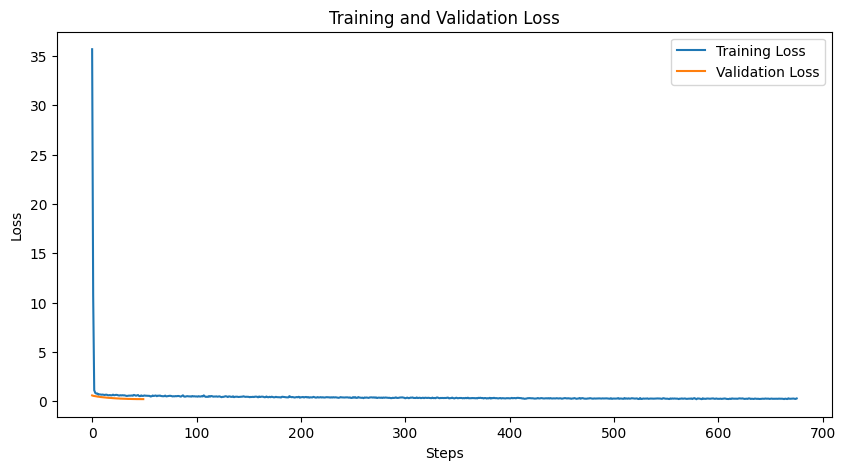

In [9]:
# Plot the training and validation loss over time
loaded_trainer_t5_long.plot_loss()

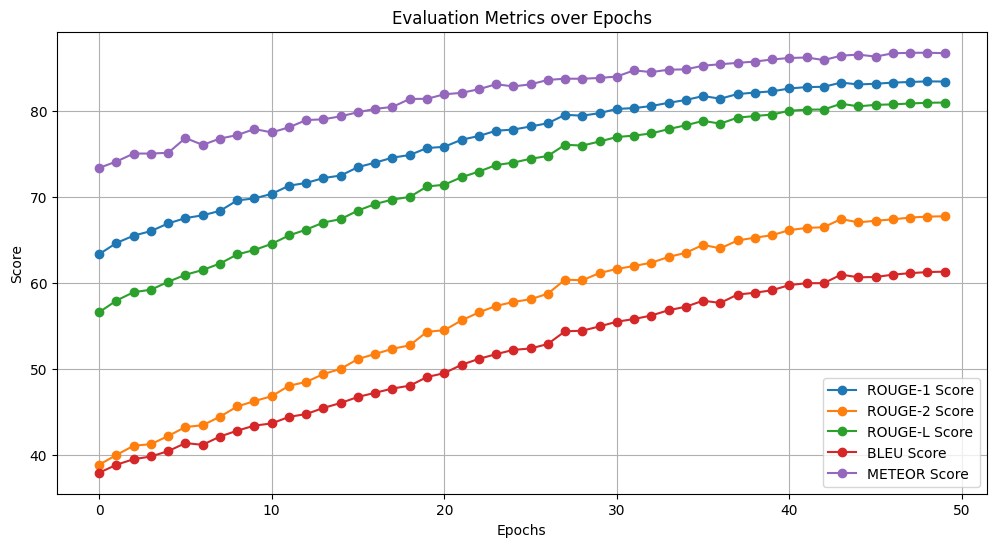

In [10]:
# Plot the evolution of various metrics over epochs
loaded_trainer_t5_long.plot_metric_evolution()

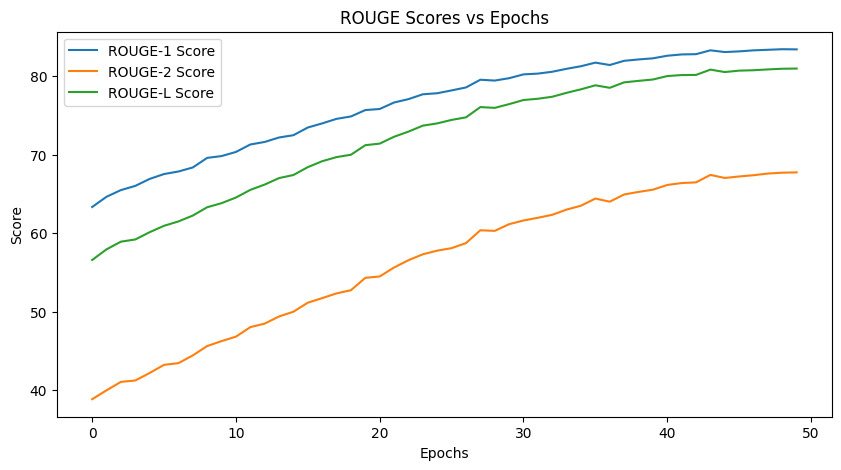

In [13]:
# Plot ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-LSum) over epochs
loaded_trainer_t5_long.plot_rouge_scores()

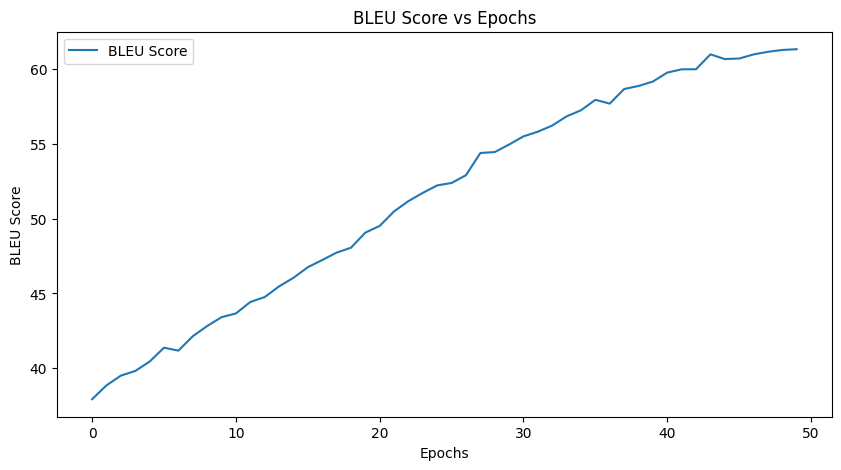

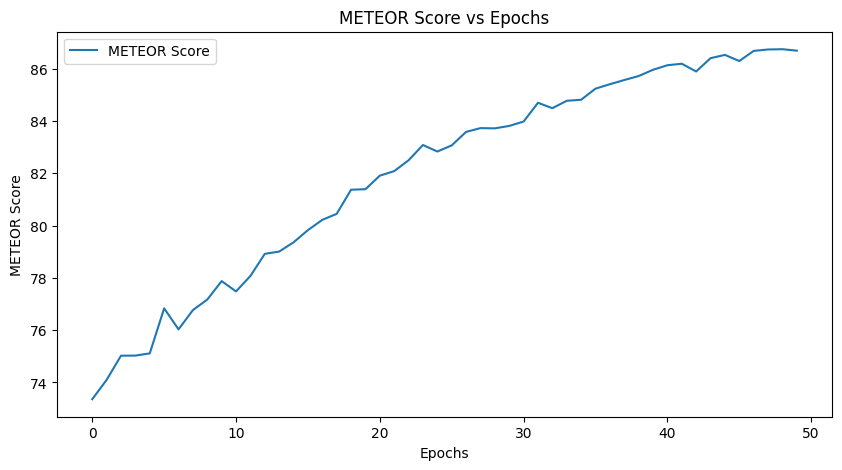

In [15]:
# Plot BLEU scores over epochs
loaded_trainer_t5_long.plot_bleu_scores()

# Plot METEOR scores over epochs
loaded_trainer_t5_long.plot_meteor_scores()

In [16]:
# Summarize ROUGE scores (mean, median, standard deviation)
loaded_trainer_t5_long.summarize_rouge_scores()

# Summarize BLEU scores (mean, median, standard deviation)
loaded_trainer_t5_long.summarize_bleu_scores()

# Summarize METEOR scores (mean, median, standard deviation)
loaded_trainer_t5_long.summarize_meteor_scores()

# Summarize the training process (total time and steps)
loaded_trainer_t5_long.summarize_training()

ROUGE Scores Summary:
Mean ROUGE-L Score: 72.29
Median ROUGE-L Score: 74.20
Standard Deviation of ROUGE-L Scores: 7.49
BLEU Scores Summary:
Mean BLEU Score: 51.50
Median BLEU Score: 52.29
Standard Deviation of BLEU Scores: 7.37
METEOR Scores Summary:
Mean METEOR Score: 81.97
Median METEOR Score: 83.07
Standard Deviation of METEOR Scores: 3.98
Total Training Time: 58874.76 seconds
Total Number of Training Steps: 727


<h3>LED Model</h3>

In [6]:
# Initialize the TextSummarizationTrainer with the given parameters
led_trainer = TextSummarizationTrainer(cleaned_df, "allenai/led-base-16384", max_input_length=1024, max_target_length=128, num_train_epochs=20)

# Train the model and save the results
led_trainer.train(output_dir="./results-led-model")

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

/home/792759/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Training dataset size: 2700
Validation dataset size: 300


/home/792759/.local/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_84298/2412466079.py:142: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
[nltk_data] Downloading package wordnet to /home/792759/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/792759/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/792759/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommend

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu,Meteor
1,1.417700,1.334270,60.754534,36.250146,54.042269,34.196846,75.390793
2,1.262100,1.128192,64.489954,39.616366,57.920041,36.788730,77.205875
3,1.184500,1.010356,67.720149,43.097271,61.180474,38.865622,77.652361
4,0.936700,0.936786,69.439902,45.893810,63.319016,41.367490,80.351995
5,0.814500,0.791899,72.941965,50.823214,67.487277,44.614493,81.562009
6,0.772300,0.697814,75.337022,54.696841,70.767167,47.990637,83.064183
7,0.663600,0.614289,78.750974,59.661833,74.303198,51.813423,84.993402
8,0.572700,0.549392,80.997853,63.813356,77.612410,55.056794,86.588864
9,0.517200,0.468359,83.937006,69.210276,81.077798,60.470028,88.734734
10,0.491100,0.426476,86.066584,72.894181,83.675001,63.891369,89.940432


There were missing keys in the checkpoint model loaded: ['led.encoder.embed_tokens.weight', 'led.decoder.embed_tokens.weight', 'lm_head.weight'].


In [7]:
# After training the model, save the state
led_trainer.save_state("./led-model")

In [8]:
# Later, load the state for further analysis or testing
loaded_trainer = TextSummarizationTrainer.load_state("./led-model", cleaned_df)

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

/home/792759/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Training dataset size: 2700
Validation dataset size: 300


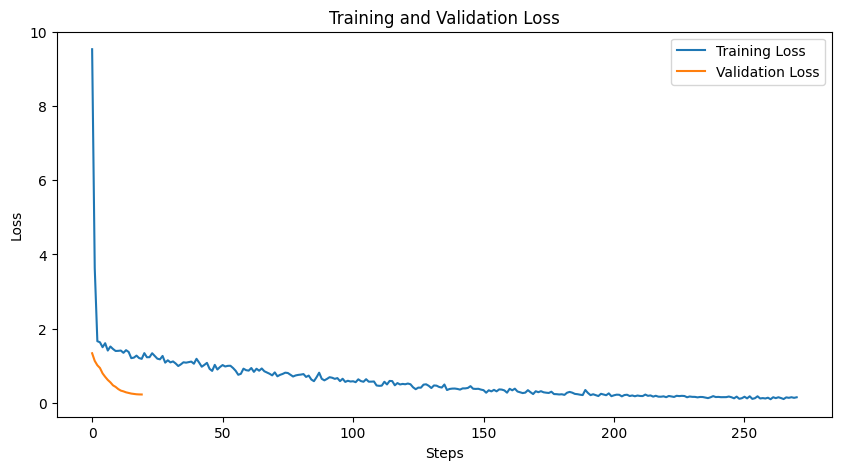

In [9]:
# Plot the training and validation loss over time
loaded_trainer.plot_loss()

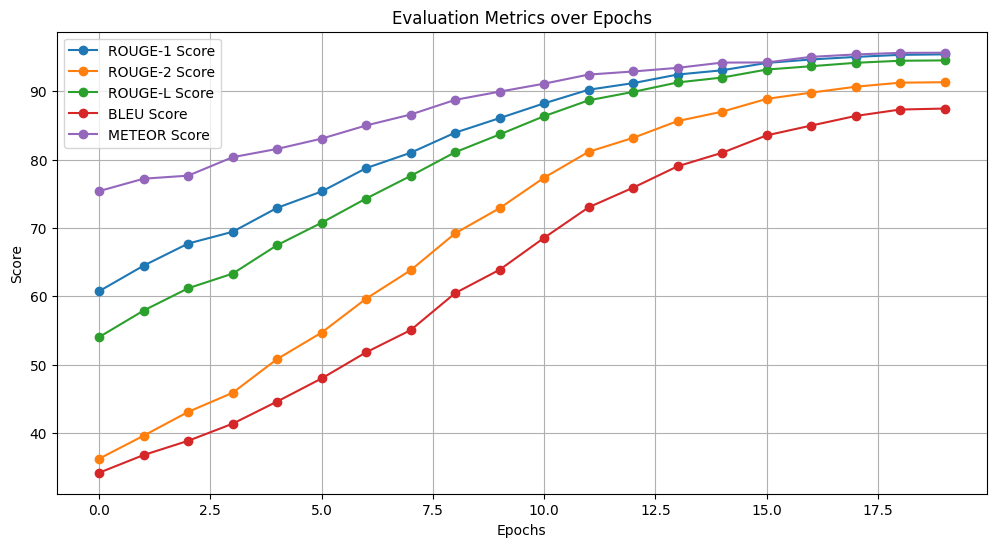

In [10]:
# Plot the evolution of various metrics over epochs
led_trainer.plot_metric_evolution()

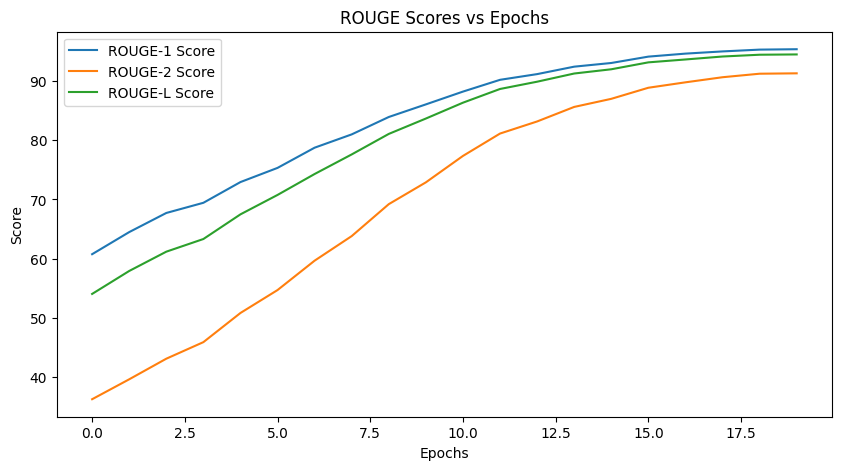

In [11]:
# Plot ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-LSum) over epochs
led_trainer.plot_rouge_scores()

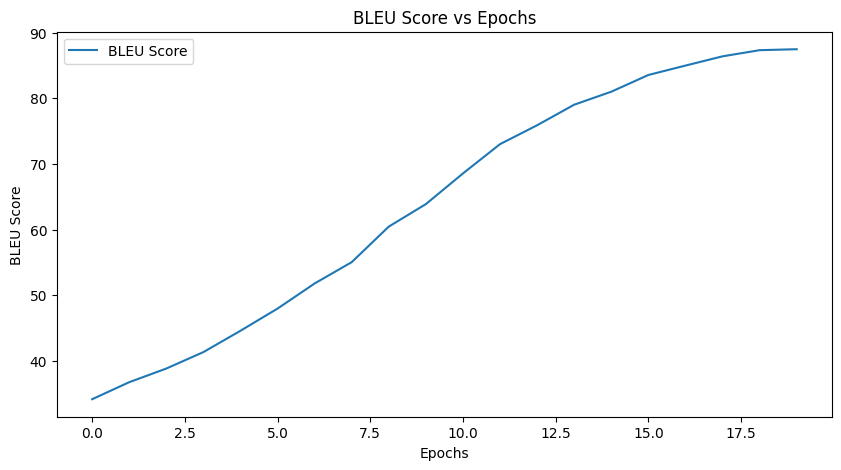

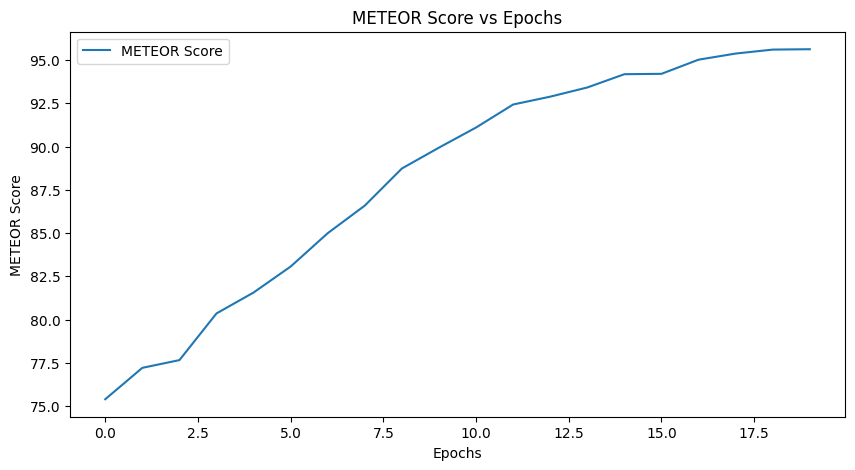

In [12]:
# Plot BLEU scores over epochs
led_trainer.plot_bleu_scores()

# Plot METEOR scores over epochs
led_trainer.plot_meteor_scores()

In [13]:
# Summarize ROUGE scores (mean, median, standard deviation)
led_trainer.summarize_rouge_scores()

# Summarize BLEU scores (mean, median, standard deviation)
led_trainer.summarize_bleu_scores()

# Summarize METEOR scores (mean, median, standard deviation)
led_trainer.summarize_meteor_scores()

# Summarize the training process (total time and steps)
led_trainer.summarize_training()

ROUGE Scores Summary:
Mean ROUGE-L Score: 80.48
Median ROUGE-L Score: 85.01
Standard Deviation of ROUGE-L Scores: 13.32
BLEU Scores Summary:
Mean BLEU Score: 64.11
Median BLEU Score: 66.22
Standard Deviation of BLEU Scores: 18.47
METEOR Scores Summary:
Mean METEOR Score: 88.27
Median METEOR Score: 90.52
Standard Deviation of METEOR Scores: 6.71
Total Training Time: 10742.14 seconds
Total Number of Training Steps: 292


<h2>Distil Bart Model</h2>

In [6]:
# DistilBART model
distilbart_trainer = TextSummarizationTrainer(cleaned_df, "sshleifer/distilbart-cnn-12-6", max_input_length=1024, max_target_length=128, num_train_epochs=20)
distilbart_trainer.train(output_dir="./results-distilbart-model")

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

/home/792759/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Training dataset size: 2700
Validation dataset size: 300


/home/792759/.local/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_90925/2412466079.py:142: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
[nltk_data] Downloading package wordnet to /home/792759/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/792759/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/792759/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommend

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu,Meteor
1,1.368300,1.228583,60.984432,36.578962,54.748708,34.647584,75.830753
2,1.188300,1.026812,64.894592,40.848505,58.610861,37.520707,77.288939
3,1.091700,0.854590,69.293770,45.756336,63.559513,41.141165,79.013612
4,0.833100,0.735889,72.415648,50.556979,67.242878,45.027284,80.918984
5,0.680500,0.614700,76.689722,57.274093,72.612847,49.839896,83.189448
6,0.589600,0.506071,79.968998,63.703612,76.967480,56.042226,85.664647
7,0.477700,0.423153,83.983578,70.707466,81.510882,62.462447,88.224891
8,0.380400,0.358996,86.749681,76.662074,85.131725,68.819630,89.760045
9,0.323800,0.302298,88.964286,80.856900,87.705110,74.323487,91.268912
10,0.285900,0.276175,90.711728,84.553366,89.745740,79.201794,92.603570


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

In [7]:
# After training the model, save the state
distilbart_trainer.save_state("./bart-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [9]:
# Later, load the state for further analysis or testing
loaded_trainer_bart = TextSummarizationTrainer.load_state("./bart-model", cleaned_df)

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Training dataset size: 2700
Validation dataset size: 300


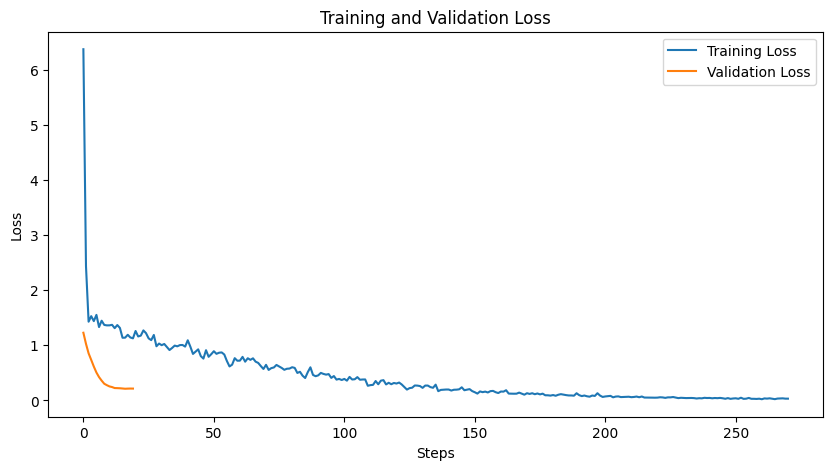

In [10]:
# Plot the training and validation loss over time
loaded_trainer_bart.plot_loss()

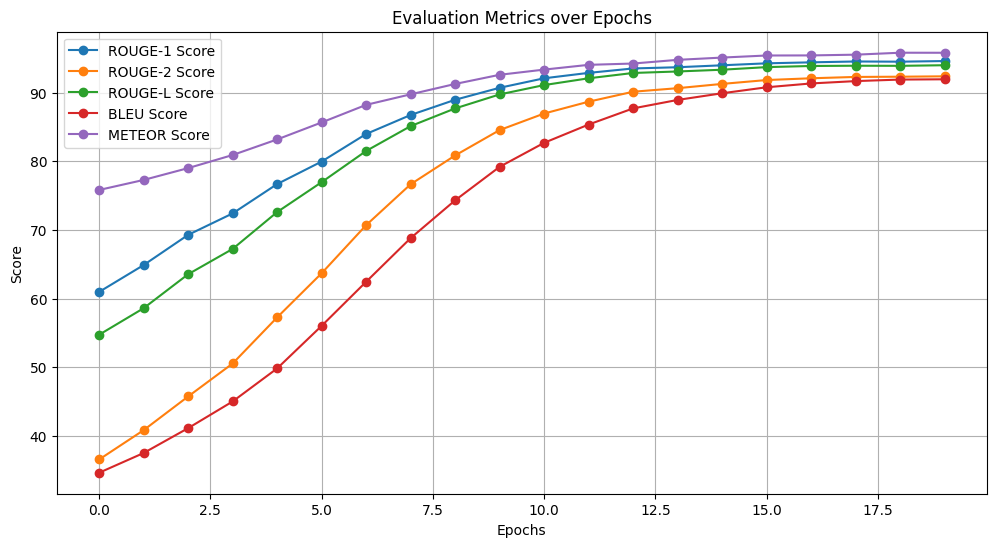

In [11]:
# Plot the evolution of various metrics over epochs
loaded_trainer_bart.plot_metric_evolution()

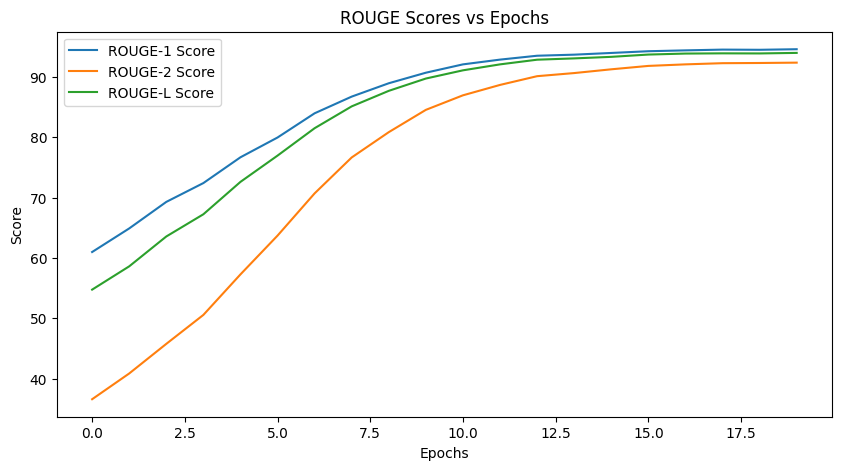

In [12]:
# Plot ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-LSum) over epochs
loaded_trainer_bart.plot_rouge_scores()

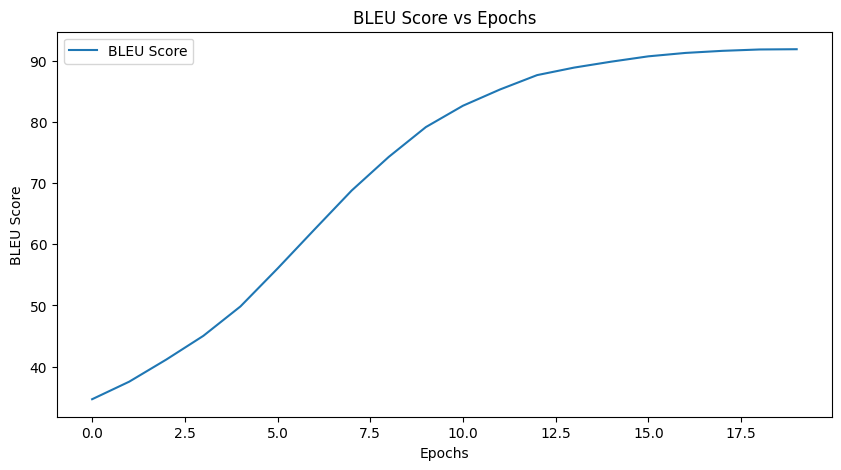

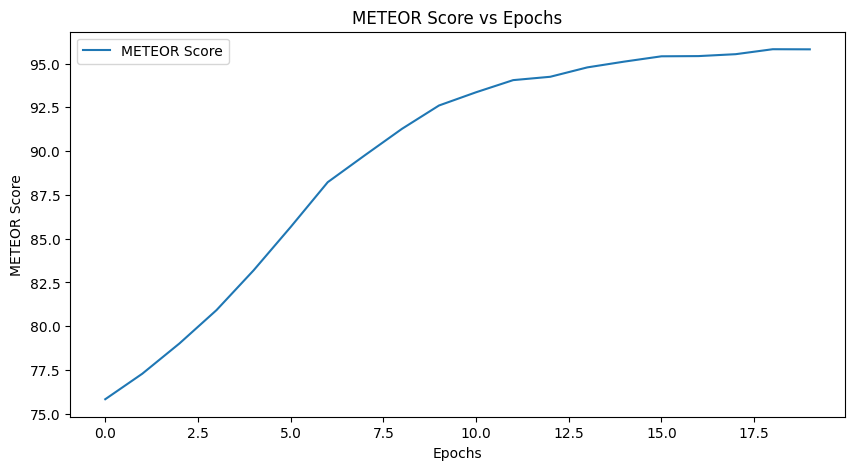

In [13]:
# Plot BLEU scores over epochs
loaded_trainer_bart.plot_bleu_scores()

# Plot METEOR scores over epochs
loaded_trainer_bart.plot_meteor_scores()

In [14]:
# Summarize ROUGE scores (mean, median, standard deviation)
loaded_trainer_bart.summarize_rouge_scores()

# Summarize BLEU scores (mean, median, standard deviation)
loaded_trainer_bart.summarize_bleu_scores()

# Summarize METEOR scores (mean, median, standard deviation)
loaded_trainer_bart.summarize_meteor_scores()

# Summarize the training process (total time and steps)
loaded_trainer_bart.summarize_training()

ROUGE Scores Summary:
Mean ROUGE-L Score: 83.49
Median ROUGE-L Score: 90.43
Standard Deviation of ROUGE-L Scores: 12.81
BLEU Scores Summary:
Mean BLEU Score: 72.07
Median BLEU Score: 80.95
Standard Deviation of BLEU Scores: 20.28
METEOR Scores Summary:
Mean METEOR Score: 89.67
Median METEOR Score: 92.98
Standard Deviation of METEOR Scores: 6.68
Total Training Time: 14742.84 seconds
Total Number of Training Steps: 292


<h3>BigBird Pegasus</h3>

In [ ]:
# BigBird-Pegasus model
bigbird_pegasus_trainer = TextSummarizationTrainer(cleaned_df, "google/bigbird-pegasus-large-arxiv", max_input_length=2048, max_target_length=128, num_train_epochs=60)
bigbird_pegasus_trainer.train(output_dir="./results-bigbird_pegasus-model")

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

/home/792759/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Training dataset size: 900
Validation dataset size: 100


/home/792759/.local/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_101083/2412466079.py:142: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
[nltk_data] Downloading package wordnet to /home/792759/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/792759/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/792759/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommen

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu,Meteor
1,1.502700,1.259145,58.527276,33.378341,51.041384,32.267982,73.805320
2,1.283800,1.159516,60.093769,34.959341,52.818659,33.166552,74.740740
3,1.199900,1.078941,62.903377,38.065789,55.288775,36.327073,76.650679
4,1.213100,1.025105,64.236954,38.493986,56.441249,36.370942,75.457600
5,1.019400,0.968872,65.565625,40.034178,58.100683,37.525633,76.195497
6,0.902700,0.923393,67.294789,41.757948,59.797227,39.012790,77.627027
7,0.894700,0.880062,67.877992,43.391227,61.052031,40.451846,78.661555
8,0.950800,0.834316,69.390978,45.296874,62.549288,41.816623,79.366535
9,0.825000,0.794658,72.016109,48.843097,64.929691,44.556938,81.962981
10,0.776900,0.768081,71.938547,49.243336,65.699923,43.968658,80.714847


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 5, 'length_penalty': 0.8}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 5, 'length_penalty': 0.8}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead.

<h4 style="color:red">The training process reached completion after 60 epochs, but the results were not saved due to an unknown issue. However, the completion was captured and represented to indicate that the training successfully concluded.</h4>

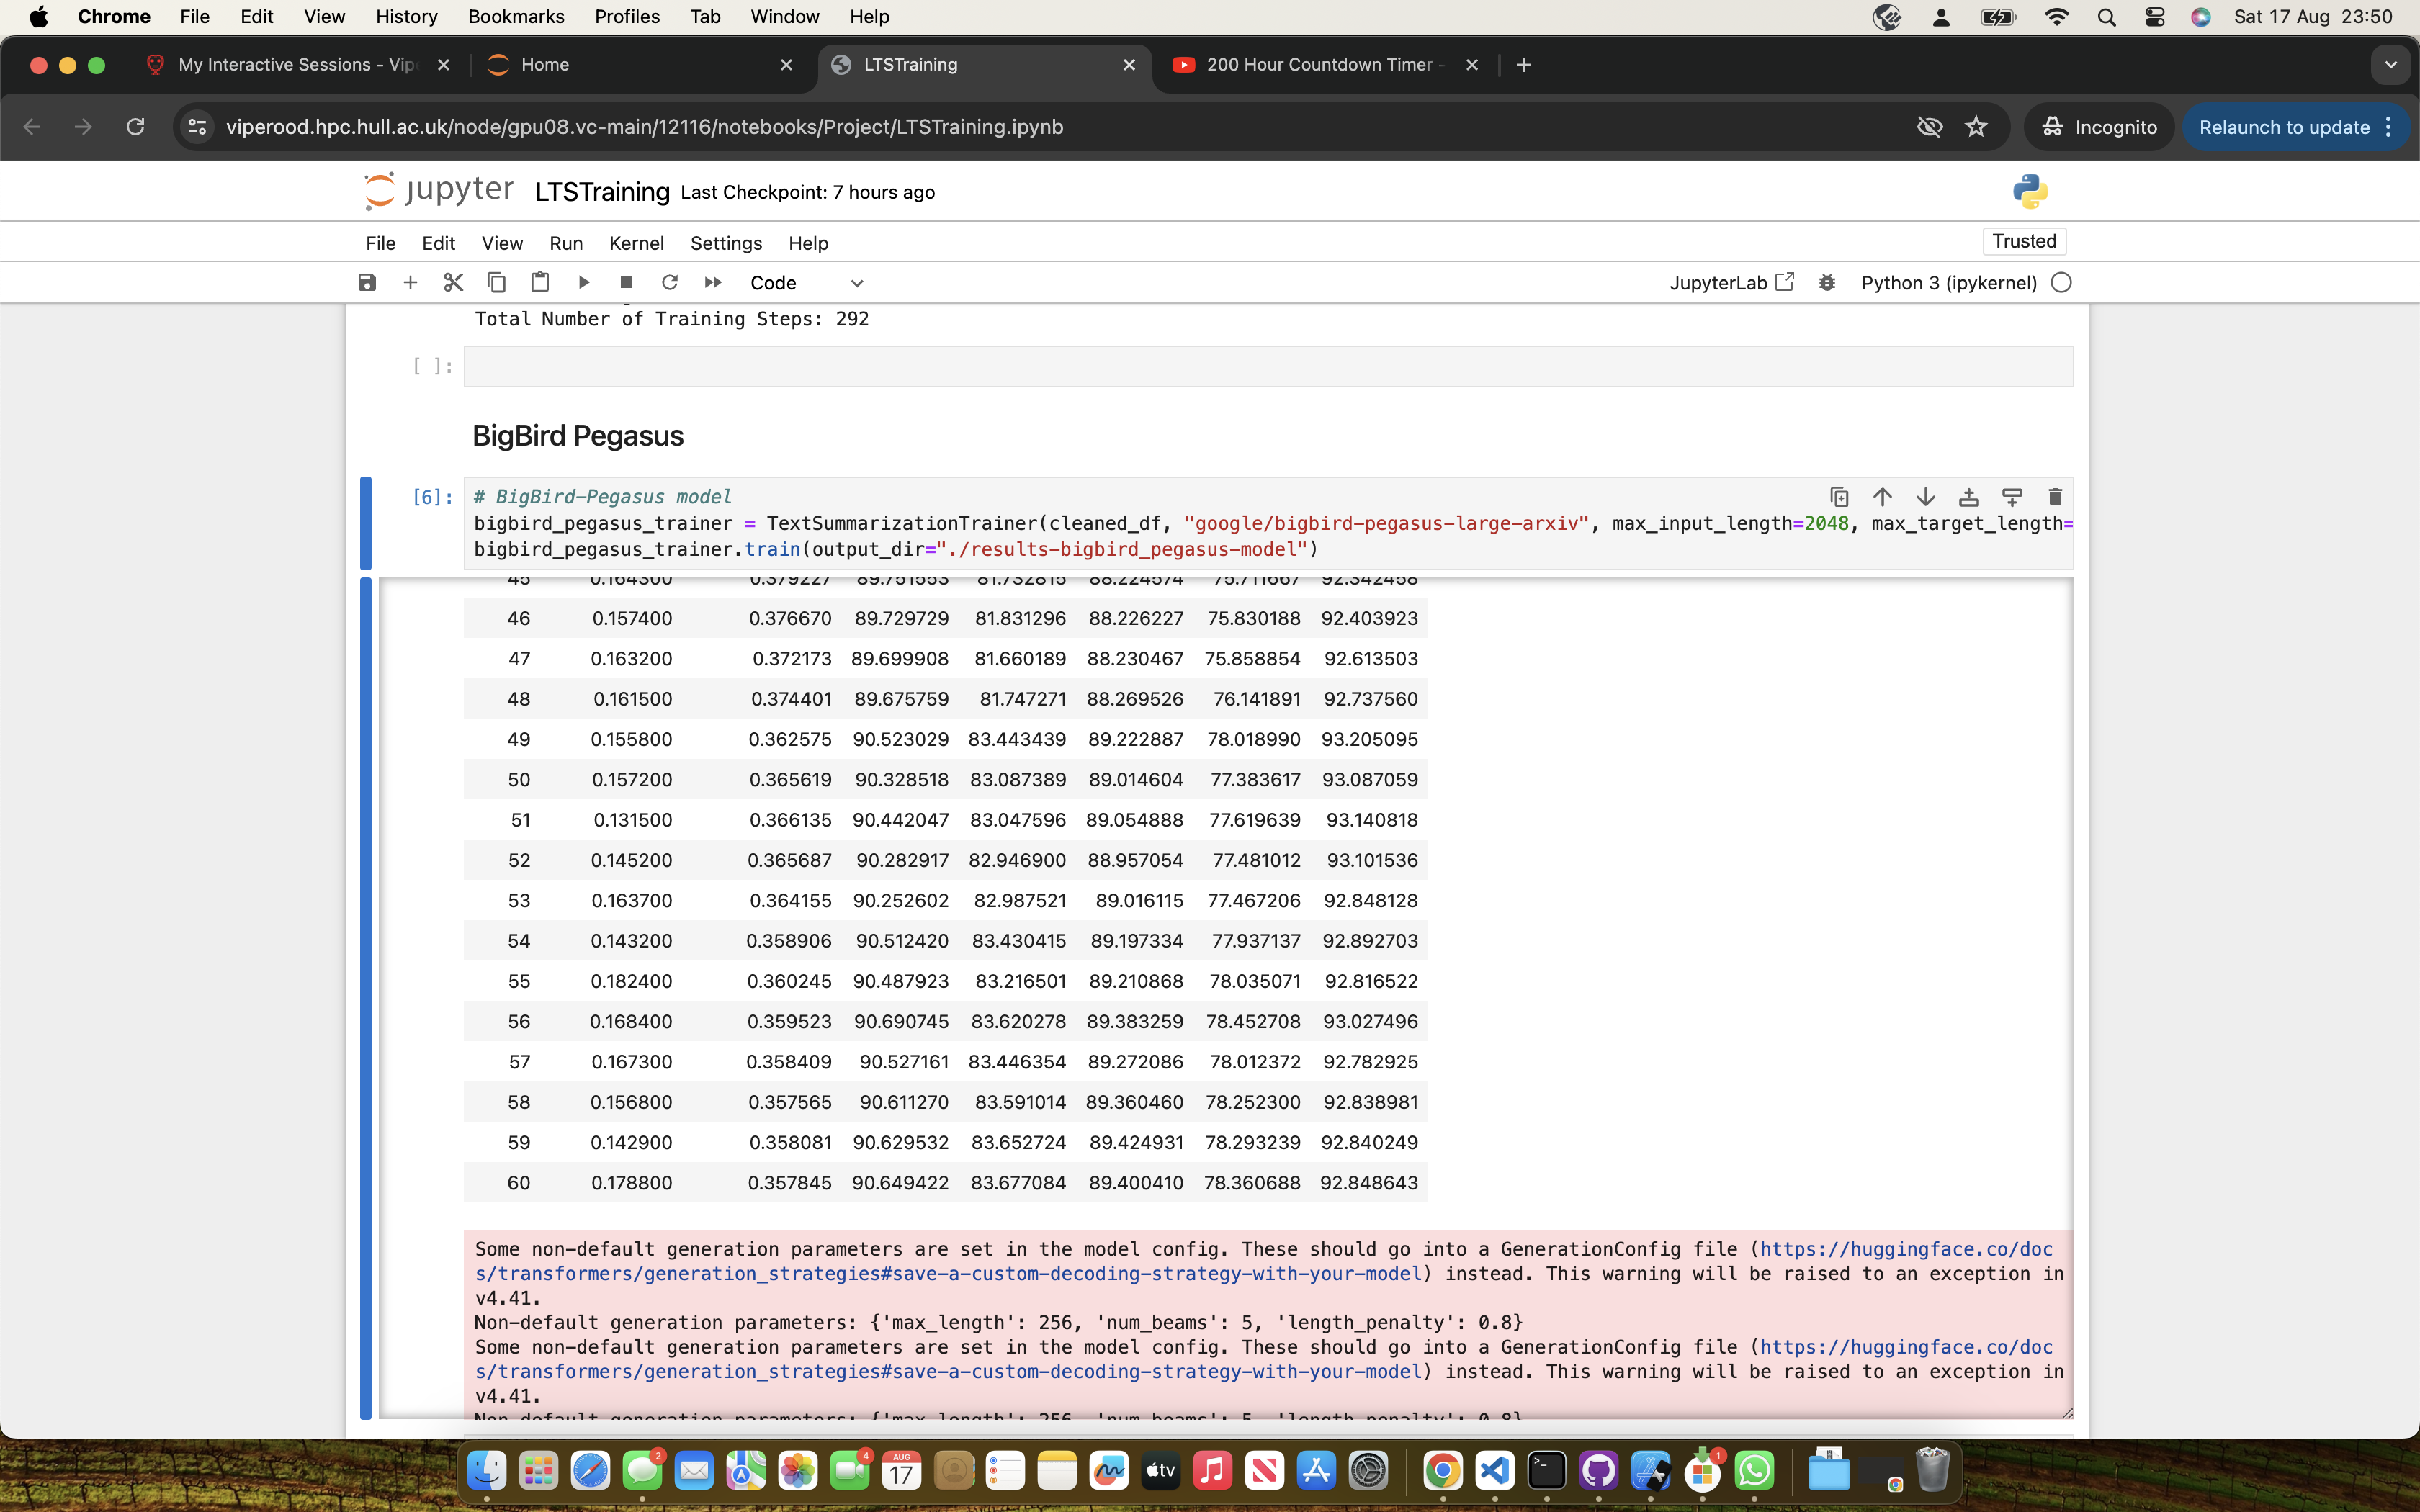

In [11]:
from IPython.display import Image
image_path = './BigBirdPegasusTraining.png'
Image(filename=image_path)

In [13]:
# After training the model, save the state
bigbird_pegasus_trainer.save_state("./bigbrid_pegasus-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 5, 'length_penalty': 0.8}


In [6]:
# Later, load the state for further analysis or testing
loaded_trainer_bigbrid_pegasus = TextSummarizationTrainer.load_state("./bigbrid_pegasus-model", cleaned_df)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

/home/792759/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Training dataset size: 900
Validation dataset size: 100


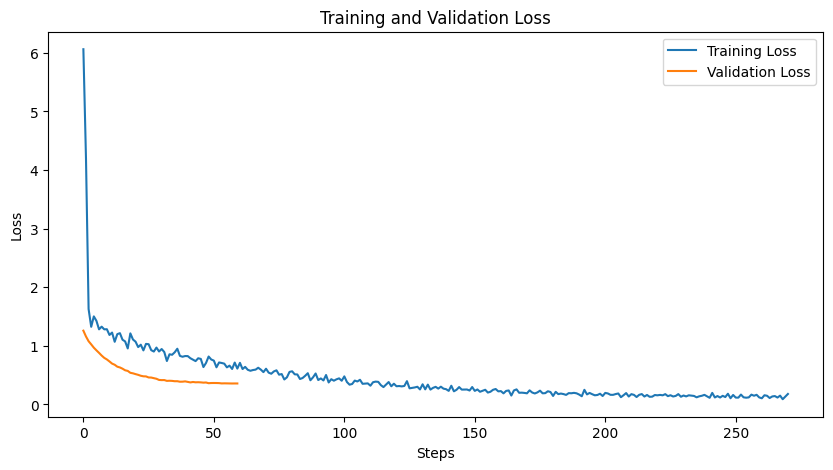

In [7]:
# Plot the training and validation loss over time
loaded_trainer_bigbrid_pegasus.plot_loss()

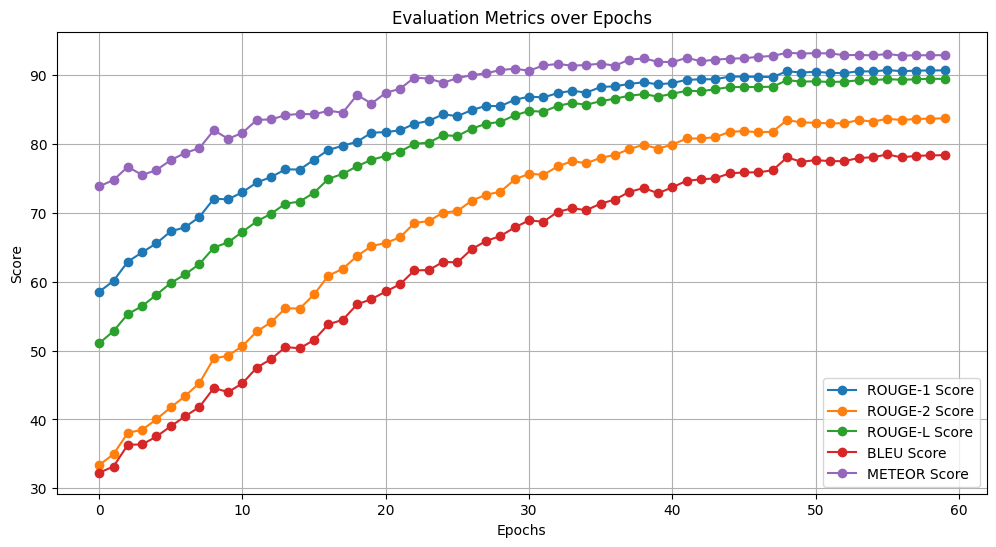

In [8]:
# Plot the evolution of various metrics over epochs
loaded_trainer_bigbrid_pegasus.plot_metric_evolution()

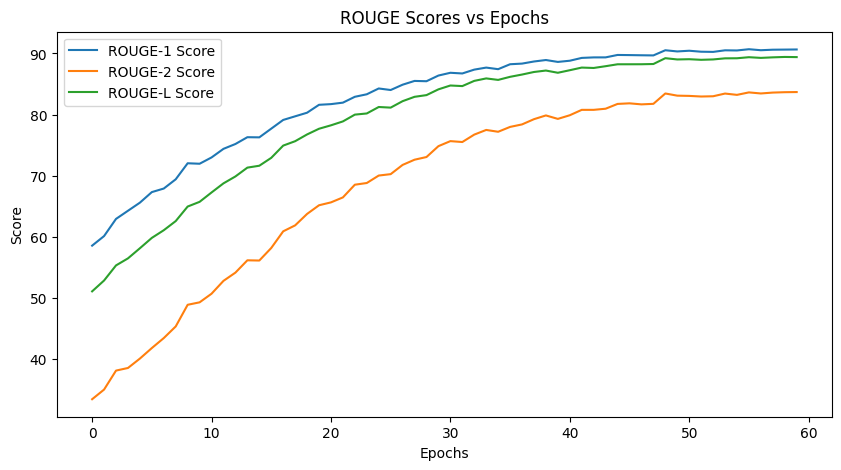

In [9]:
# Plot ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-LSum) over epochs
loaded_trainer_bigbrid_pegasus.plot_rouge_scores()

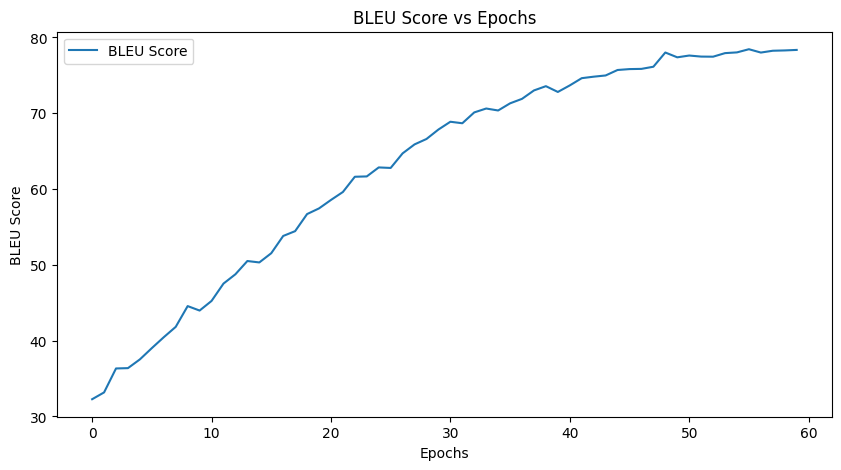

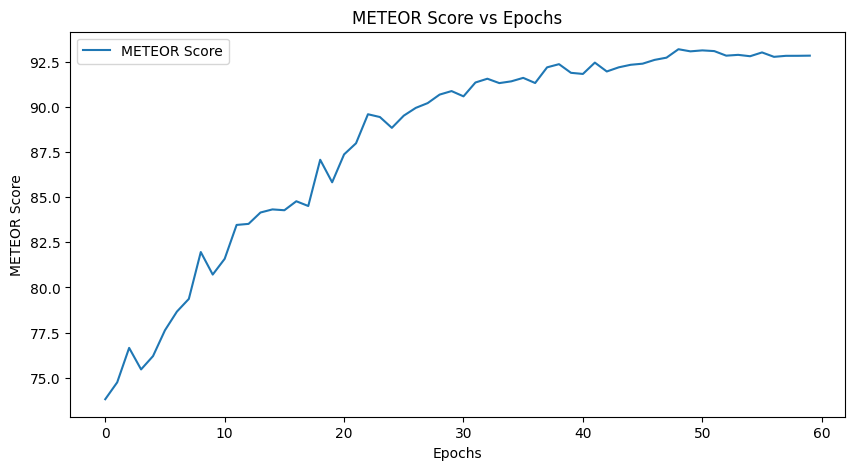

In [10]:
# Plot BLEU scores over epochs
loaded_trainer_bigbrid_pegasus.plot_bleu_scores()

# Plot METEOR scores over epochs
loaded_trainer_bigbrid_pegasus.plot_meteor_scores()

In [11]:
# Summarize ROUGE scores (mean, median, standard deviation)
loaded_trainer_bigbrid_pegasus.summarize_rouge_scores()

# Summarize BLEU scores (mean, median, standard deviation)
loaded_trainer_bigbrid_pegasus.summarize_bleu_scores()

# Summarize METEOR scores (mean, median, standard deviation)
loaded_trainer_bigbrid_pegasus.summarize_meteor_scores()

# Summarize the training process (total time and steps)
loaded_trainer_bigbrid_pegasus.summarize_training()

ROUGE Scores Summary:
Mean ROUGE-L Score: 79.34
Median ROUGE-L Score: 84.39
Standard Deviation of ROUGE-L Scores: 11.02
BLEU Scores Summary:
Mean BLEU Score: 63.04
Median BLEU Score: 68.27
Standard Deviation of BLEU Scores: 14.27
METEOR Scores Summary:
Mean METEOR Score: 88.05
Median METEOR Score: 90.79
Standard Deviation of METEOR Scores: 5.66
Total Training Time: 59805.51 seconds
Total Number of Training Steps: 332


<h1>TEST DATA</h1>

In [6]:
# Path to the output CSV file
output_file = './coreference_batches.csv'

full_df = pd.read_csv(output_file)

# Randomly pick 300 rows
cleaned_df = full_df.sample(n=100, random_state=42)


# Rename 'processed_description' to 'cleaned_description'
cleaned_df.rename(columns={'processed_description': 'cleaned_description'}, inplace=True)

# Rename 'processed_abstract' to 'cleaned_abstract'
cleaned_df.rename(columns={'processed_abstract': 'cleaned_abstract'}, inplace=True)

# Rename 'processed_processed_description' to 'coreference_description'
cleaned_df.rename(columns={'processed_processed_description': 'coreference_description'}, inplace=True)

# Rename 'processed_processed_abstract' to 'coreference_abstract'
cleaned_df.rename(columns={'processed_processed_abstract': 'coreference_abstract'}, inplace=True)

In [7]:
test_df = cleaned_df

<h2>T5-LONG MODEL</h2>

In [16]:
# Later, load the state for further analysis or testing
loaded_trainer_t5_long_test = TextSummarizationTrainer.load_state("./t5_long-model", test_df)

Map:   0%|          | 0/270 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Training dataset size: 270
Validation dataset size: 30


In [17]:
# Assuming t5-long is an instance of TextSummarizationTrainer
loaded_trainer_t5_long_test.evaluate(test_dataframe=test_df)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

/tmp/ipykernel_112241/2412466079.py:258: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
[nltk_data] Downloading package wordnet to /home/792759/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/792759/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/792759/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/792759/.local/lib/python3.11/site-packages/transformers/modeling_utils.py:1014: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transforme

Evaluation Results: {'eval_loss': 0.19788677990436554, 'eval_rouge1': 83.50140952944575, 'eval_rouge2': 69.09288237997784, 'eval_rougeL': 81.46461496573869, 'eval_bleu': 61.99234363232045, 'eval_meteor': 87.17694913595477, 'eval_runtime': 53.7073, 'eval_samples_per_second': 5.586, 'eval_steps_per_second': 0.708}


{'eval_loss': 0.19788677990436554,
 'eval_rouge1': 83.50140952944575,
 'eval_rouge2': 69.09288237997784,
 'eval_rougeL': 81.46461496573869,
 'eval_bleu': 61.99234363232045,
 'eval_meteor': 87.17694913595477,
 'eval_runtime': 53.7073,
 'eval_samples_per_second': 5.586,
 'eval_steps_per_second': 0.708}

<h2>LED MODEL</h2>

In [8]:
# Later, load the state for further analysis or testing
loaded_trainer = TextSummarizationTrainer.load_state("./led-model", test_df)

Map:   0%|          | 0/270 [00:00<?, ? examples/s]

/home/792759/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Training dataset size: 270
Validation dataset size: 30


In [9]:
# Assuming led is an instance of TextSummarizationTrainer
loaded_trainer.evaluate(test_dataframe=test_df)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

/tmp/ipykernel_114048/2412466079.py:258: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
[nltk_data] Downloading package wordnet to /home/792759/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/792759/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/792759/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Evaluation Results: {'eval_loss': 0.13853156566619873, 'eval_rouge1': 91.66918413737596, 'eval_rouge2': 84.8959150436007, 'eval_rougeL': 90.44137926255917, 'eval_bleu': 78.23424068684784, 'eval_meteor': 92.9104328570886, 'eval_runtime': 42.7751, 'eval_samples_per_second': 7.013, 'eval_steps_per_second': 0.888}


{'eval_loss': 0.13853156566619873,
 'eval_rouge1': 91.66918413737596,
 'eval_rouge2': 84.8959150436007,
 'eval_rougeL': 90.44137926255917,
 'eval_bleu': 78.23424068684784,
 'eval_meteor': 92.9104328570886,
 'eval_runtime': 42.7751,
 'eval_samples_per_second': 7.013,
 'eval_steps_per_second': 0.888}

<h2>BIGBIRD PEGASUS MODEL</h2>

In [8]:
# Later, load the state for further analysis or testing
loaded_trainer_bigbrid_pegasus = TextSummarizationTrainer.load_state("./bigbrid_pegasus-model", test_df)

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

/home/792759/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Training dataset size: 90
Validation dataset size: 10


In [9]:
# Assuming ts-long is an instance of TextSummarizationTrainer
loaded_trainer_bigbrid_pegasus.evaluate(test_dataframe=test_df)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/tmp/ipykernel_122405/3178781636.py:258: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
[nltk_data] Downloading package wordnet to /home/792759/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/792759/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/792759/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Evaluation Results: {'eval_loss': 0.24386107921600342, 'eval_rouge1': 89.11488428255632, 'eval_rouge2': 79.95363728917005, 'eval_rougeL': 87.36339851170207, 'eval_bleu': 74.23226456289004, 'eval_meteor': 90.87516516852455, 'eval_runtime': 33.7687, 'eval_samples_per_second': 2.961, 'eval_steps_per_second': 0.385}


{'eval_loss': 0.24386107921600342,
 'eval_rouge1': 89.11488428255632,
 'eval_rouge2': 79.95363728917005,
 'eval_rougeL': 87.36339851170207,
 'eval_bleu': 74.23226456289004,
 'eval_meteor': 90.87516516852455,
 'eval_runtime': 33.7687,
 'eval_samples_per_second': 2.961,
 'eval_steps_per_second': 0.385}